# SAOS Protocol Validation

**Validates Small Amplitude Oscillatory Shear data: G'(ω), G''(ω)**

## Protocol Description

SAOS experiments apply small-amplitude oscillatory strain and measure the in-phase (G') and
out-of-phase (G'') stress components. This characterizes the material's linear viscoelastic response.

## Validation Checks

1. **Schema validation**: Required columns present (frequency, G', G'')
2. **Finite values**: No NaN or Inf in data arrays
3. **Positive frequency**: ω > 0 (strictly positive)
4. **Monotonic frequency**: Frequency monotonically changing
5. **Non-negative moduli**: G' ≥ 0, G'' ≥ 0
6. **Derived quantities**: |G*|, tan(δ)

## Standard Plots

- G', G'' vs ω (log-log)
- tan(δ) vs ω

In [1]:
# Configuration
MODE = "FAST"  # "FAST" or "FULL"

if MODE == "FAST":
    MAX_FILES = 2
    SKIP_HEAVY_PLOTS = True
    SAVE_ARTIFACTS = False
else:
    MAX_FILES = None
    SKIP_HEAVY_PLOTS = False
    SAVE_ARTIFACTS = True

print(f"Running in {MODE} mode")

Running in FAST mode


In [2]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Add project root to path
project_root = Path.cwd()
while not (project_root / "pyproject.toml").exists() and project_root != project_root.parent:
    project_root = project_root.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from examples.verification.utils.validation_utils import (
    DatasetValidation,
    ValidationResult,
    check_finite,
    check_monotonic,
    check_positive,
    compute_saos_derived,
    create_output_directories,
    discover_files_by_protocol,
    get_data_dir,
    plot_saos,
    print_validation_summary,
    write_validation_report,
)

print(f"Project root: {project_root}")

Project root: /Users/b80985/Projects/rheojax


## A) Dataset Inventory

In [3]:
data_dir = get_data_dir()
files = discover_files_by_protocol(data_dir, "saos")

# Filter to main oscillation files (not DMA framework files)
files = [f for f in files if "oscillation" in f.name.lower() or f.suffix == ".csv"]

print(f"Found {len(files)} SAOS data files:")
for i, f in enumerate(files[:10]):
    print(f"  {i+1}. {f.relative_to(data_dir)}")
if len(files) > 10:
    print(f"  ... and {len(files) - 10} more")

if MAX_FILES is not None:
    files = files[:MAX_FILES]
    print(f"\nProcessing {len(files)} files (FAST mode)")

Found 15 SAOS data files:
  1. oscillation/polyisoprene/PI_1131k_T-35.csv
  2. oscillation/polyisoprene/PI_13.5k_T-35.csv
  3. oscillation/polyisoprene/PI_2.4k_T-35.csv
  4. oscillation/polyisoprene/PI_225.9k_T-35.csv
  5. oscillation/polyisoprene/PI_33.6k_T-35.csv
  6. oscillation/polyisoprene/PI_483.1k_T-35.csv
  7. oscillation/polyisoprene/PI_94.9k_T-35.csv
  8. oscillation/polyisoprene/PI_94.9k_T-35_TH_h.csv
  9. oscillation/metal_networks/epstein.csv
  10. oscillation/foods/oscillation_chia_data.csv
  ... and 5 more

Processing 2 files (FAST mode)


## B) Data Loading

In [4]:
def load_saos_data(file_path: Path) -> tuple[np.ndarray, np.ndarray, np.ndarray, str]:
    """Load SAOS data with format auto-detection.
    
    Returns:
        Tuple of (omega, G_prime, G_double_prime, status_message)
    """
    # Try different separators
    for sep in ["\t", ",", ";"]:
        try:
            df = pd.read_csv(file_path, sep=sep)
            if len(df.columns) >= 3:
                break
        except Exception:
            continue
    else:
        return None, None, None, "Could not parse file"
    
    # Find frequency column
    freq_cols = [c for c in df.columns if "freq" in c.lower() or "omega" in c.lower() or "angular" in c.lower()]
    if not freq_cols:
        freq_col = df.columns[0]
    else:
        freq_col = freq_cols[0]
    
    # Find G' and G'' columns
    gp_cols = [c for c in df.columns if "storage" in c.lower() or "g'" in c.lower() or "g_prime" in c.lower()]
    gpp_cols = [c for c in df.columns if "loss" in c.lower() or "g''" in c.lower() or "g_double" in c.lower()]
    
    if not gp_cols:
        gp_col = df.columns[1] if len(df.columns) > 1 else None
    else:
        gp_col = gp_cols[0]
    
    if not gpp_cols:
        gpp_col = df.columns[2] if len(df.columns) > 2 else None
    else:
        gpp_col = gpp_cols[0]
    
    if gp_col is None or gpp_col is None:
        return None, None, None, "Missing G' or G'' column"
    
    try:
        omega = pd.to_numeric(df[freq_col], errors="coerce").values
        G_prime = pd.to_numeric(df[gp_col], errors="coerce").values
        G_double_prime = pd.to_numeric(df[gpp_col], errors="coerce").values
    except Exception as e:
        return None, None, None, f"Numeric conversion failed: {e}"
    
    # Remove NaN values
    mask = np.isfinite(omega) & np.isfinite(G_prime) & np.isfinite(G_double_prime)
    omega = omega[mask]
    G_prime = G_prime[mask]
    G_double_prime = G_double_prime[mask]
    
    return omega, G_prime, G_double_prime, f"Loaded {len(omega)} points from {freq_col}, {gp_col}, {gpp_col}"

# Test loading
if files:
    test_file = files[0]
    omega, Gp, Gpp, msg = load_saos_data(test_file)
    print(f"Test load: {test_file.name}")
    print(f"  {msg}")
    if omega is not None:
        print(f"  ω range: [{omega.min():.2e}, {omega.max():.2e}] rad/s")
        print(f"  G' range: [{Gp.min():.2e}, {Gp.max():.2e}] Pa")
        print(f"  G'' range: [{Gpp.min():.2e}, {Gpp.max():.2e}] Pa")

Test load: PI_1131k_T-35.csv
  Loaded 180 points from Angular Frequency, Storage Modulus, Loss Modulus
  ω range: [4.18e-08, 8.40e+01] rad/s
  G' range: [3.46e+03, 9.93e+05] Pa
  G'' range: [1.15e+04, 1.01e+06] Pa


## C) Validation Pipeline

In [5]:
def validate_saos(file_path: Path) -> DatasetValidation:
    """Run all validation checks on a SAOS file."""
    validation = DatasetValidation(
        file_path=str(file_path),
        protocol="saos",
    )
    
    omega, G_prime, G_double_prime, load_msg = load_saos_data(file_path)
    
    if omega is None:
        validation.results.append(ValidationResult(
            check_name="data_loading",
            passed=False,
            message=load_msg,
        ))
        return validation
    
    validation.results.append(ValidationResult(
        check_name="data_loading",
        passed=True,
        message=load_msg,
        details={"n_points": len(omega)},
    ))
    
    # Check 1: Finite values
    validation.results.append(check_finite(omega, "frequency"))
    validation.results.append(check_finite(G_prime, "G_prime"))
    validation.results.append(check_finite(G_double_prime, "G_double_prime"))
    
    # Check 2: Positive frequency
    validation.results.append(check_positive(omega, "frequency", strict=True))
    
    # Check 3: Monotonic frequency (either direction is fine)
    is_increasing = omega[-1] > omega[0] if len(omega) > 1 else True
    mono_result = check_monotonic(omega, "frequency", increasing=is_increasing, strict=False)
    validation.results.append(mono_result)
    
    # Check 4: Non-negative moduli
    validation.results.append(check_positive(G_prime, "G_prime", strict=False))
    validation.results.append(check_positive(G_double_prime, "G_double_prime", strict=False))
    
    # Compute derived quantities
    derived = compute_saos_derived(omega, G_prime, G_double_prime)
    
    # Check tan(delta) range
    tan_delta = derived["tan_delta"]
    valid_td = tan_delta[np.isfinite(tan_delta)]
    if len(valid_td) > 0:
        td_range = f"[{valid_td.min():.3f}, {valid_td.max():.3f}]"
        # Classify material behavior
        mean_td = np.mean(valid_td)
        if mean_td < 0.1:
            behavior = "solid-like"
        elif mean_td > 1:
            behavior = "liquid-like"
        else:
            behavior = "viscoelastic"
    else:
        td_range = "N/A"
        behavior = "unknown"
    
    validation.results.append(ValidationResult(
        check_name="tan_delta_range",
        passed=True,
        message=f"tan(δ) = {td_range} ({behavior})",
        details={"mean_tan_delta": float(np.nanmean(tan_delta)), "behavior": behavior},
    ))
    
    # Sort by frequency for storage
    sort_idx = np.argsort(omega)
    validation.derived_quantities = {
        "omega": omega[sort_idx],
        "G_prime": G_prime[sort_idx],
        "G_double_prime": G_double_prime[sort_idx],
        "G_star": derived["G_star"][sort_idx],
        "tan_delta": derived["tan_delta"][sort_idx],
    }
    
    return validation

In [6]:
# Run validation on all files
validations = []

for file_path in files:
    print(f"\nValidating: {file_path.name}")
    v = validate_saos(file_path)
    validations.append(v)
    
    for r in v.results:
        status = "PASS" if r.passed else "FAIL"
        print(f"  [{status}] {r.check_name}: {r.message}")


Validating: PI_1131k_T-35.csv
  [PASS] data_loading: Loaded 180 points from Angular Frequency, Storage Modulus, Loss Modulus
  [PASS] finite_values_frequency: frequency: all 180 values finite
  [PASS] finite_values_G_prime: G_prime: all 180 values finite
  [PASS] finite_values_G_double_prime: G_double_prime: all 180 values finite
  [PASS] positive_frequency: frequency: all 180 values positive (> 0)
  [PASS] monotonic_frequency: frequency: all 179 intervals non-decreasing
  [PASS] positive_G_prime: G_prime: all 180 values non-negative (>= 0)
  [PASS] positive_G_double_prime: G_double_prime: all 180 values non-negative (>= 0)
  [PASS] tan_delta_range: tan(δ) = [0.031, 6.587] (viscoelastic)

Validating: PI_13.5k_T-35.csv
  [PASS] data_loading: Loaded 65 points from Angular Frequency, Storage Modulus, Loss Modulus
  [PASS] finite_values_frequency: frequency: all 65 values finite
  [PASS] finite_values_G_prime: G_prime: all 65 values finite
  [PASS] finite_values_G_double_prime: G_double_p

## D) Standard Plots

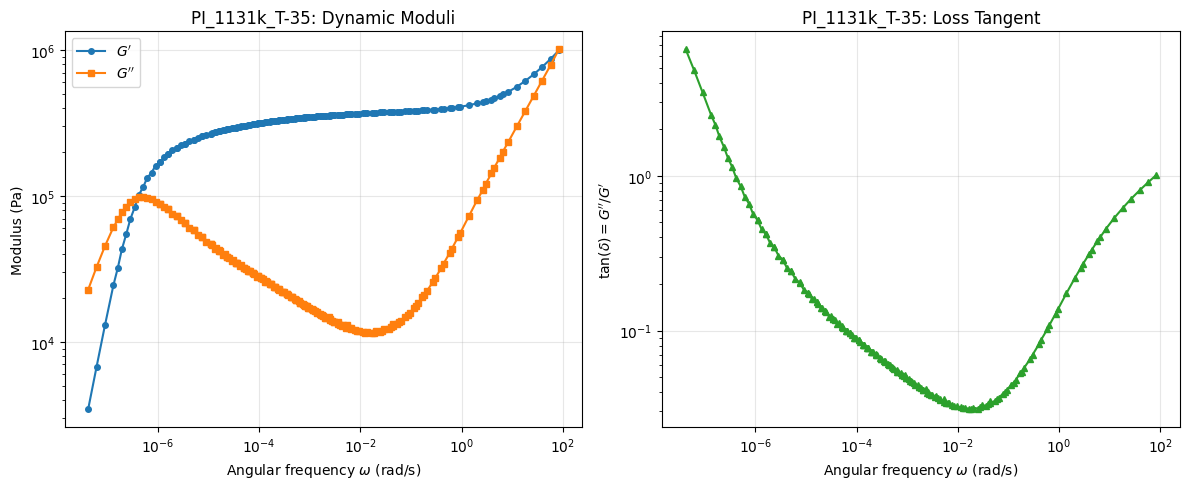

In [7]:
if not SKIP_HEAVY_PLOTS:
    output_paths = create_output_directories("saos")
    
    for v in validations:
        if v.passed and "omega" in v.derived_quantities:
            file_name = Path(v.file_path).stem
            save_path = output_paths["plots"] / f"{file_name}_saos.png" if SAVE_ARTIFACTS else None
            
            fig = plot_saos(
                v.derived_quantities["omega"],
                v.derived_quantities["G_prime"],
                v.derived_quantities["G_double_prime"],
                save_path=save_path,
                title=file_name,
            )
            plt.show()
else:
    for v in validations:
        if v.passed and "omega" in v.derived_quantities:
            fig = plot_saos(
                v.derived_quantities["omega"],
                v.derived_quantities["G_prime"],
                v.derived_quantities["G_double_prime"],
                title=Path(v.file_path).stem,
            )
            plt.show()
            break

## E) Validation Summary

In [8]:
print_validation_summary(validations)


Validation Summary
File                                     Status     Passed   Failed  
--------------------------------------------------------------------------------
PI_1131k_T-35.csv                        PASS       9        0       
PI_13.5k_T-35.csv                        PASS       9        0       
--------------------------------------------------------------------------------
TOTAL                                    ALL PASS   18       0       


## F) Export Artifacts

In [9]:
if SAVE_ARTIFACTS:
    output_paths = create_output_directories("saos")
    
    report = {
        "protocol": "saos",
        "mode": MODE,
        "n_files_validated": len(validations),
        "all_passed": all(v.passed for v in validations),
        "validations": validations,
    }
    
    report_path = output_paths["plots"].parent / "validation_report.json"
    write_validation_report(report, report_path)
    print(f"Validation report saved to: {report_path}")
    
    for v in validations:
        if v.passed and "omega" in v.derived_quantities:
            file_name = Path(v.file_path).stem
            df = pd.DataFrame({
                "omega": v.derived_quantities["omega"],
                "G_prime": v.derived_quantities["G_prime"],
                "G_double_prime": v.derived_quantities["G_double_prime"],
                "G_star": v.derived_quantities["G_star"],
                "tan_delta": v.derived_quantities["tan_delta"],
            })
            df.to_csv(output_paths["derived_quantities"] / f"{file_name}_derived.csv", index=False)
    
    print(f"Derived quantities saved to: {output_paths['derived_quantities']}")
else:
    print("Artifacts not saved (FAST mode). Set MODE='FULL' to save.")

Artifacts not saved (FAST mode). Set MODE='FULL' to save.
